# Tutorial 1: Build a Semi-distributed Hydrological Model
To get familiar with the HydroCNHS model construction process, let’s start with a hydrological model without human components. 

We adopted the following delineated watershed as a demonstration (Figure 1), in which we want to build a semi-distributed hydrological model to simulate the streamflow at the basin outlet, WSLO. The corresponding subbasins’ information is provided in Table 1.

<img src="./NB_Figs/example_watershed.png" alt="Example watershed." width="400"/>

*Figure 1. Example watershed*

*Table 1. Subbasins’ information*
| Subbasin/outlet | Drainage area [ha] | Latitude [deg] | Flow length to WSLO [m] |
|-----------------|-------------------:|---------------:|------------------------:|
| Hagg            | 10034.2408         | 45.469         | 101469.139              |
| DLLO            | 22568.2404         | 45.475         | 91813.075               |
| TRGC            | 24044.6363         | 45.502         | 80064.864               |
| DAIRY           | 59822.7546         | 45.520         | 70988.164               |
| RCTV            | 19682.6046         | 45.502         | 60398.680               |
| WSLO            | 47646.8477         | 45.350         | 0                       |



In [1]:
import os
import pandas as pd
import hydrocnhs

## Run a simulation

First, let's set up the working directory to run this tutorial.

In [6]:
# Set the working directory to the tutorial 1 folder
wd = os.path.abspath(
    os.path.join(
        os.path.dirname(hydrocnhs.__file__),
        '..', 'tutorials',
        'Tutorial_1-Build_a_Semi-distributed_Hydrological_Model'
        )
    )

print(wd)

C:\Users\CL\Documents\GitHub\HydroCNHS\tutorials\Tutorial_1-Build_a_Semi-distributed_Hydrological_Model


Then, we load the climate inputs, including temperature, precipitation, and potential evapotranspiration, from `.csv` and convert them into `dictionaries`.

In [7]:
# Load climate inputs
data_path = os.path.join(wd, "Data")

temp = pd.read_csv(
    os.path.join(data_path, "Temp_degC.csv"), index_col=["Date"]
).to_dict(orient="list")

prec = pd.read_csv(os.path.join(data_path, "Prec_cm.csv"), index_col=["Date"]).to_dict(
    orient="list"
)

pet = pd.read_csv(os.path.join(data_path, "Pet_cm.csv"), index_col=["Date"]).to_dict(
    orient="list"
)

Next, we load a calibrated model to give a taste of how a simulation looks like before jumping into details about how to construct and calibrated model.

The `Model` in HydroCNHS is defined in a single `.yaml` file. The file will be loaded into Python and displayed as a `dictionary`. We highly recommend that you open `Best_HydroModel_gwlf_KGE.yaml`, located in `Tutorial_1-Build_a_Semi-distributed_Hydrological_Model/Cali_HydroModel_gwlf_KGE/Cali_HydroModel_gwlf_KGE`, to get a quick look at how a model is constructed.


In [8]:
# Add model path
model_path = os.path.join(
    wd, "Cali_HydroModel_gwlf_KGE", "Best_HydroModel_gwlf_KGE.yaml"
    )
print(model_path)

# Load the model
model_dict = hydrocnhs.load_model(model_path)
# Here we manually change the working directory in the model directory
model_dict["Path"]["WD"] = wd

C:\Users\CL\Documents\GitHub\HydroCNHS\tutorials\Tutorial_1-Build_a_Semi-distributed_Hydrological_Model\Cali_HydroModel_gwlf_KGE\Best_HydroModel_gwlf_KGE.yaml


After `Best_HydroModel_gwlf_KGE.yaml` is loaded, a summary printout shows a single routing outlet, 'WSLO,' with no other agents listed.

Now, we can apply `model_dict` to create a model object for the simulation.

In [9]:
# Create the model object
model = hydrocnhs.Model(model_dict)

With that, we can start the simulation by calling `run` method with climate inputs as arguments.

In [10]:
# Run a simulation.
Q = model.run(temp, prec, pet)

# Ture the output to a pandas DataFrame. Here, we resample the daily output to monthly.
results = pd.DataFrame(Q, index=model.pd_date_index).resample("MS").mean()
print(results.head())

12053it [00:01, 11782.04it/s]


                Hagg       DLLO       TRGC      DAIRY       RCTV        WSLO
1981-01-01  7.273348  18.361993  13.012307  35.574340  15.314707  107.655192
1981-02-01  7.460241  17.127556  16.271473  27.850362  10.889746  111.406767
1981-03-01  2.193627   2.973636   4.601788   8.421741   5.609668   91.983965
1981-04-01  2.641500   5.206177   5.414842   9.204536   3.864405   71.431304
1981-05-01  0.303622   0.005892   0.094642   0.056155   2.825899   38.073646


Below, we compare the simulated discharge at WSLO (routing outlet) with the observation.

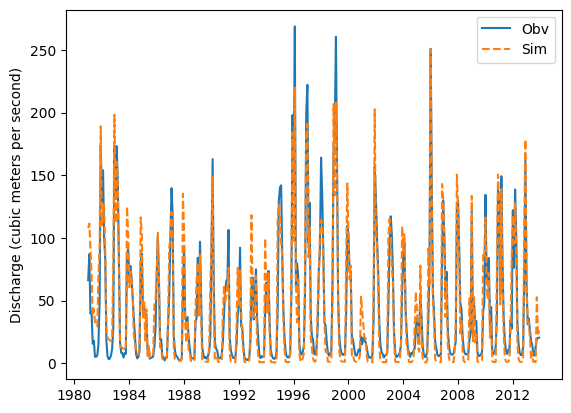

In [11]:
import matplotlib.pyplot as plt

# Load the observed flow data
obv_flow_WSLO = pd.read_csv(
    os.path.join(wd, "Data", "WSLO_M_cms.csv"), index_col=["Date"], parse_dates=["Date"]
)

# Plot
fig, ax = plt.subplots()
ax.plot(obv_flow_WSLO.index, obv_flow_WSLO.loc[:, "WSLO"], label="Obv")
ax.plot(obv_flow_WSLO.index, results["WSLO"], ls="--", label="Sim")
ax.set_ylabel("Discharge (cubic meters per second)")
ax.legend()

## Construct a model

Now, we have experience how to run a simulation using `HydroCNHS`. Next, we want to dive a little bit further to construct a model ourselves. 

To that, HydroCNHS includes a model builder designed to assist users in creating a draft `model.yaml` file.

First, initialize a model builder object with a working directory. The instructions will then pop out to help you create a model file. You can recall the instructions by calling `mb.help()`.

In [12]:
# We reuse the working directory used above.
mb = hydrocnhs.ModelBuilder(wd)

Follow the following steps to create model & ABM script templates:
	Step 1: set_water_system()
	Step 2: set_rainfall_runoff()
	Step 3: set_routing_outlet(), one at a time.
	Step 4: (optional) set_sediment().
	Step 5: (optional) add_sediment(), one at a time.
	Step 6: (optional) set_ABM().
	Step 7: (optional) add_agent().
	Step 8: (optional) add_institution().
	Step 9: write_model_to_yaml()
	Step 10: (optional) gen_ABM_script_template()
Open the generated draft 'model.yaml' (& ABM module template) and further edit them.
Use .help to re-print the above instructions.


Following the instructions, we first configure a water system by setting the simulation period, which includes the start and end dates.

In [13]:
mb.set_water_system(start_date="1981/1/1", end_date="2013/12/31")

Then, we can add subbasins (i.e., `outlet_list`) to the model. We adopt the GWLF model as the rainfall-runoff model (i.e., `runoff_model`). We also assign the corresponding subbasins' areas (i.e., `area_list`) and latitudes (i.e., `lat_list`) using the information from Table 4. Note that `area_list` and `lat_list` are optional arguments. Users can manually enter this information into the `model.yaml` file.


In [14]:
# outlet list includes all the outlets in the model, routing outlets and non-routing outlets.
outlet_list = ['Hagg', 'DLLO', 'TRGC', 'DAIRY', 'RCTV', 'WSLO']
area_list = [10034.2408, 22568.2404, 24044.6363, 59822.7546, 19682.6046, 47646.8477]
lat_list = [45.469, 45.475, 45.502, 45.520, 45.502, 45.350]
mb.set_rainfall_runoff(
    outlet_list=outlet_list,area_list=area_list,
    lat_list=lat_list, runoff_model="GWLF"
    )

Next, we specify the routing outlet setting. Here, we only have one routing outlet, WSLO, hence, we only need to run the following code once, and all the outlets are considered upstream outlets of WSLO.

In [15]:
flow_length_list = [101469.139, 91813.075, 80064.864, 70988.164, 60398.680, 0] # km
mb.set_routing_outlet(
    routing_outlet="WSLO",
    upstream_outlet_list=outlet_list,
    flow_length_list=flow_length_list
    )

Since we don't have any agents in this tutorial, we have done all the setup. We can print out the model for quick view and then write it to `model.yaml` file.

In [16]:
# Print the model in the console
mb.print_model()

# Output draft model configuration file (model.yaml)
mb.write_model_to_yaml(filename="model.yaml")

Path
  WD
    C:\Users\CL\Documents\GitHub\HydroCNHS\tutorials\Tutorial_1-Build_a_Semi-distributed_Hydrological_Model
  Modules
    
WaterSystem
  StartDate
    1981/1/1
  EndDate
    2013/12/31
  DataLength
    12053
  NumSubbasins
    6
  Outlets
    ['Hagg', 'DLLO', 'TRGC', 'DAIRY', 'RCTV', 'WSLO']
  NodeGroups
    []
  RainfallRunoff
    GWLF
  Routing
    Lohmann
  ABM
    None
RainfallRunoff
  Hagg
    Inputs
      {'Area': 10034.2408, 'Latitude': 45.469, 'S0': 2, 'U0': 10, 'SnowS': 5}
    Pars
      {'CN2': -99, 'IS': -99, 'Res': -99, 'Sep': -99, 'Alpha': -99, 'Beta': -99, 'Ur': -99, 'Df': -99, 'Kc': -99}
  DLLO
    Inputs
      {'Area': 22568.2404, 'Latitude': 45.475, 'S0': 2, 'U0': 10, 'SnowS': 5}
    Pars
      {'CN2': -99, 'IS': -99, 'Res': -99, 'Sep': -99, 'Alpha': -99, 'Beta': -99, 'Ur': -99, 'Df': -99, 'Kc': -99}
  TRGC
    Inputs
      {'Area': 24044.6363, 'Latitude': 45.502, 'S0': 2, 'U0': 10, 'SnowS': 5}
    Pars
      {'CN2': -99, 'IS': -99, 'Res': -99, 'Sep': -99, 'A

## Model calibraion

Before applying the draft `model.yaml` for calibration, we need to ensure the information is correct. 

The "Inputs" in the `LSM` and `Routing` sections should all be populated. Some default values may be used (e.g., `S0`, `U0`, and `SnowS`). They should be updated according to the user's needs. For this tutorial, no modifications are needed. You might notice that all the parameters have a value of `-99`. This is the default value in HydroCNHS, indicating that those values are subject to calibration if not provided by the user.

Below, we provide a sample calibration code using genetic algorithm (GA) and Kling-Gupta efficiency (KGE) at WSLO as the objective. The calibration will take around 2 to 3 hours depending on your hardware.

Note: By running the following code, the entire `Cali_HydroModel_gwlf_KGE` folder will be overwritten. 

In [18]:
import pandas as pd
import hydrocnhs.calibration as cali
from copy import deepcopy

# Load climate inputs
temp = pd.read_csv(
    os.path.join(wd, "Data", "Temp_degC.csv"), index_col=["Date"]
).to_dict(orient="list")
prec = pd.read_csv(os.path.join(wd, "Data", "Prec_cm.csv"), index_col=["Date"]).to_dict(
    orient="list"
)
pet = pd.read_csv(os.path.join(wd, "Data", "Pet_cm.csv"), index_col=["Date"]).to_dict(
    orient="list"
)

# Load flow gauge monthly data at WSLO
obv_flow_WSLO = pd.read_csv(
    os.path.join(wd, "Data", "WSLO_M_cms.csv"), index_col=["Date"], parse_dates=["Date"]
)

# Load model (the model can be loaded by giving the path of the model configuration file)
model_dict = hydrocnhs.load_model(os.path.join(wd, "model.yaml"))

# Generate default parameter bounds
df_list, df_name = hydrocnhs.write_model_to_df(model_dict)
par_bound_df_list, df_name = hydrocnhs.gen_default_bounds(model_dict)

# Create convertor for calibration. Check the manual for converter details.
converter = cali.Convertor()
cali_inputs = converter.gen_cali_inputs(wd, df_list, par_bound_df_list)
formatter = converter.formatter

# Code evaluation function for GA algorthm
def evaluation(individual, info):
    cali_wd, current_generation, ith_individual, formatter, _ = info
    name = "{}-{}".format(current_generation, ith_individual)

    ##### individual -> model
    # Convert 1D array to a list of dataframes.
    df_list = cali.Convertor.to_df_list(individual, formatter)
    # Feed dataframes in df_list to model dictionary.
    model = deepcopy(model_dict)
    for i, df in enumerate(df_list):
        s = df_name[i].split("_")[0]
        model = hydrocnhs.load_df_to_model_dict(model, df, s, "Pars")

    ##### Run simuluation
    model = hydrocnhs.Model(model, name)
    Q = model.run(temp, prec, pet)

    ##### Get simulation data
    # Streamflow of routing outlets.
    cali_target = ["WSLO"]
    cali_period = ("1981-1-1", "2005-12-31")
    sim_Q_D = pd.DataFrame(Q, index=model.pd_date_index)[cali_target]
    # Resample the daily simulation output to monthly outputs.
    sim_Q_M = sim_Q_D[cali_target].resample("MS").mean()

    KGE = hydrocnhs.Indicator().get_kge(
        x_obv=obv_flow_WSLO[cali_period[0] : cali_period[1]][cali_target],
        y_sim=sim_Q_M[cali_period[0] : cali_period[1]][cali_target],
    )

    fitness = KGE
    return (fitness,)


config = {
    "min_or_max": "max",
    "pop_size": 100,
    "num_ellite": 1,
    "prob_cross": 0.5,
    "prob_mut": 0.15,
    "stochastic": False,
    "max_gen": 100,
    "sampling_method": "LHC",
    "drop_record": False,
    "paral_cores": -1,
    "paral_verbose": 1,
    "auto_save": True,
    "print_level": 1,
    "plot": True,
}

seed = 5
rn_gen = hydrocnhs.create_rn_gen(seed)
ga = cali.GA_DEAP(evaluation, rn_gen)
ga.set(cali_inputs, config, formatter, name="Cali_HydroModel_gwlf_KGE")
ga.run()
summary = ga.summary
individual = ga.solution

##### Output the calibrated model.
df_list = cali.Convertor.to_df_list(individual, formatter)
model_best = deepcopy(model_dict)
for i, df in enumerate(df_list):
    s = df_name[i].split("_")[0]
    model = hydrocnhs.load_df_to_model_dict(model_best, df, s, "Pars")
hydrocnhs.write_model(
    model_best, os.path.join(ga.cali_wd, "Best_HydroModel_gwlf_KGE.yaml")
)

GA Calibration Guide
Step 1: set or load (GA_auto_save.pickle).
Step 2: run.
[01/02 10:41:20] HydroCNHS.GA [WARNING] Current calibration folder exists. Default to overwrite the folder!
C:\Users\CL\Documents\GitHub\HydroCNHS\tutorials\Tutorial_1-Build_a_Semi-distributed_Hydrological_Model\Cali_HydroModel_gwlf_KGE


c:\Users\CL\miniconda3\envs\drb\Lib\site-packages\hydrocnhs\util.py:271: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[25, 100]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[k, :] = str(v)
c:\Users\CL\miniconda3\envs\drb\Lib\site-packages\hydrocnhs\util.py:271: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[25, 100]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[k, :] = str(v)
c:\Users\CL\miniconda3\envs\drb\Lib\site-packages\hydrocnhs\util.py:271: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[25, 100]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[k, :] = str(v)
c:\Users\CL\miniconda3\envs\


=====Generation 0=====
  Elapsed time 00:01:25
  Min 0.22605
  Max 0.92429
  Avg 0.66237
  Std 0.14465


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 1=====
  Elapsed time 00:02:39
  Min 0.23829
  Max 0.92537
  Avg 0.69316
  Std 0.14193


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 2=====
  Elapsed time 00:03:51
  Min 0.25742
  Max 0.93526
  Avg 0.69808
  Std 0.13554


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.3min finished



=====Generation 3=====
  Elapsed time 00:05:08
  Min 0.36877
  Max 0.93526
  Avg 0.73055
  Std 0.1181


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 4=====
  Elapsed time 00:06:23
  Min 0.42374
  Max 0.93526
  Avg 0.7443
  Std 0.11081


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 5=====
  Elapsed time 00:07:37
  Min 0.38773
  Max 0.93526
  Avg 0.76297
  Std 0.1106


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.3min finished



=====Generation 6=====
  Elapsed time 00:08:57
  Min 0.45166
  Max 0.93526
  Avg 0.79287
  Std 0.09685


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 7=====
  Elapsed time 00:10:11
  Min 0.54428
  Max 0.93985
  Avg 0.80099
  Std 0.09372


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 8=====
  Elapsed time 00:11:25
  Min 0.55846
  Max 0.93985
  Avg 0.80806
  Std 0.09316


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 9=====
  Elapsed time 00:12:39
  Min 0.46108
  Max 0.93985
  Avg 0.81603
  Std 0.09173


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.3min finished



=====Generation 10=====
  Elapsed time 00:13:57
  Min 0.50799
  Max 0.93985
  Avg 0.83759
  Std 0.08041


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.2min finished



=====Generation 11=====
  Elapsed time 00:15:14
  Min 0.609
  Max 0.93985
  Avg 0.83651
  Std 0.07855


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.9s


KeyboardInterrupt: 